In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           3259  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44          11251  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates           4KB  2020-11-26 00:21:15           3456  
afrniomelo/3w-dataset                                        3W Dataset - Undesirable events in oil wells   658MB  2020-11-21 21:22:49            503  
arashnic/hr-analytics-job-ch

In [3]:
!kaggle datasets download -d stackoverflow/stacksample

stacksample.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip stacksample.zip

Archive:  stacksample.zip
replace Answers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Answers.csv             y
y

replace Questions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: Questions.csv           y

replace Tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: Tags.csv                


In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Imports

In [6]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression


In [7]:
questions = pd.read_csv('Questions.csv',encoding="ISO-8859-1")
tags = pd.read_csv('Tags.csv', encoding="ISO-8859-1")

# Question Structure

In [8]:
#Question Structure
idx = 800
Id = questions.Id[idx]
title = questions.Title[idx]
body = questions.Body[idx]
score = questions.Score[idx]
print("ID :",Id)
print("Title :", title)
print("Body :", body)
curr_tags = tags[tags.Id == Id]['Tag']
tags_str = ", ".join(curr_tags.tolist())
print("Score :",score)
print("Tags :", tags_str)

ID : 65800
Title : What's the best HTML WYSISYG editor available to web developers and why?
Body : <p>There are many different flavored HTML WYSIWYG editors from javascript to ASP.Net web controls, but all too often the features are the same.  Does anyone have a favorite HTML editor they like to use in projects?  Why?</p>

Score : 12
Tags : asp.net, javascript, html, editor, wysiwyg


In [9]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


# Merge Questions with Tags

In [10]:
tags = tags.groupby('Id').agg(lambda x: x.tolist())
tags['Tag'] = tags['Tag'].str.join(" ")

In [11]:
tags.head()

,Tag
Id,
80,flex actionscript-3 air
90,svn tortoisesvn branch branching-and-merging
120,sql asp.net sitemap
180,algorithm language-agnostic colors color-space
260,c# .net scripting compiler-construction


In [12]:
questions.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [13]:
df = pd.merge(questions, tags, on='Id')

In [14]:
df.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


# Preprocessing Data

In [15]:
def removeHtmlTags(data):
    cleaner = re.compile('<.*?>')
    clean_text = re.sub(cleaner," ",str(data))
    return clean_text
sent = "<html><p>hello world</p></html>"
rece = removeHtmlTags(sent)
print(rece)

  hello world  


In [16]:
preprossed_data = []
questions_proccesed = 0
data_size = 300000

In [17]:
start = datetime.now()
questions_with_code=0
for i in range(min(data_size, len(questions))):
    is_code = 0

    title = df['Title'][i]
    question = df['Body'][i]
    tag = df['Tag'][i]
    
    # checking if the body has a code
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    # Storing code from body in code variable
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    # removing code from body
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    # removing html tags from questions
    question=removeHtmlTags(question.encode('utf-8'))
    title=title.encode('utf-8')
    # question = question + title
    question=str(title)+" "+str(question)
    
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    tup = (question,code,is_code,tag)
    preprossed_data.append(tup)
    questions_proccesed += 1
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)
    
print("Time take to execute this cell ", datetime.now()-start)

number of questions completed= 10000
number of questions completed= 20000
number of questions completed= 30000
number of questions completed= 40000
number of questions completed= 50000
number of questions completed= 60000
number of questions completed= 70000
number of questions completed= 80000
number of questions completed= 90000
number of questions completed= 100000
number of questions completed= 110000
number of questions completed= 120000
number of questions completed= 130000
number of questions completed= 140000
number of questions completed= 150000
number of questions completed= 160000
number of questions completed= 170000
number of questions completed= 180000
number of questions completed= 190000
number of questions completed= 200000
number of questions completed= 210000
number of questions completed= 220000
number of questions completed= 230000
number of questions completed= 240000
number of questions completed= 250000
number of questions completed= 260000
number of questions c

In [18]:
preprossed_data[70]

('programmat iter datagrid row sudden back winform year web develop troubl someth simpl busi object bound window form like user abl edit cell finish press save button point like iter row column find chang save databas find way access row also want valid individu cell real time edit pretti sure done mayb iter quit surpris seem possibl must realli stuff busi object data datat order use datagrid',
 "['ArrayList', 'DataGrid', 'DataGrid', 'DataGrid', 'ArrayList', 'DataSource', 'DataGrid']",
 1,
 'winforms')

In [19]:
data = pd.DataFrame(preprossed_data[:data_size], columns =['question', 'code', 'is_code','tag'])
data.drop(['is_code','code'], axis =1, inplace=True)

In [20]:
data.head(10)

,question,tag
0,sqlstatement execut multipl queri one statemen...,flex actionscript-3 air
1,good branch merg tutori tortoisesvn realli goo...,svn tortoisesvn branch branching-and-merging
2,asp net site map anyon got experi creat sql ba...,sql asp.net sitemap
3,function creat color wheel someth pseudo solv ...,algorithm language-agnostic colors color-space
4,ad script function net applic littl game writt...,c# .net scripting compiler-construction
5,use nest class case work collect class use vid...,c++ oop class nested-class
6,homegrown consumpt web servic write web servic...,.net web-services
7,deploy sql server databas test live wonder guy...,sql-server sql-server-2005 deployment release-...
8,automat updat version number would like versio...,c# visual-studio versioning
9,visual studio setup project per user registri ...,windows visual-studio registry installation


# Converting Y to vector

In [21]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
Y = vectorizer.fit_transform(data['tag'].values.astype('U'))

In [22]:
print(vectorizer.get_feature_names()[0:85])
print(len(vectorizer.get_feature_names()))

['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.emf', '.htaccess', '.htpasswd', '.ico', '.lib', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-assembly', '.net-attributes', '.net-cf-3.5', '.net-client-profile', '.net-framework-source', '.net-framework-version', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-security', '.netrc', '.nettiers', '.obj', '.post', '.profile', '.sbr', '.war', '.x', '128bit', '16-bit', '1wire', '2-legged', '2-satisfiability', '2-tier', '2-way-object-databinding', '2.5d', '24bit', '256color', '2d', '2d-games', '2phase-commit', '3-tier', '32-bit', '3270', '32bit-64bit', '360-degrees', '37-signals', '3d', '3d-engine', '3d-modelling', '3d-reconstruction', '3d-studio', '3dcamera', '3des', '3ds', '3dsmax', '3g', '3gp', '3nf', '4d', '4d-database', '4g', '4gl', '4store', '4th-dimension', '51degrees', '64bit', '6502', '68000', '777', '7bit', '7zip', '8-puzzle', 

In [23]:
def tags_to_choose(n):
    t = Y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=Y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_covered_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [24]:
Y.shape

(300000, 20551)

In [25]:
questions_covered = []
total_tags=Y.shape[1]
total_qs=data.shape[0]
for i in range(50, total_tags, 50):
    questions_covered.append(np.round(((total_qs-questions_covered_fn(i))/total_qs)*100,3))

In [26]:
questions_covered[:10]

[77.482,
 85.355,
 88.952,
 90.703,
 92.121,
 93.039,
 93.854,
 94.379,
 94.961,
 95.417]

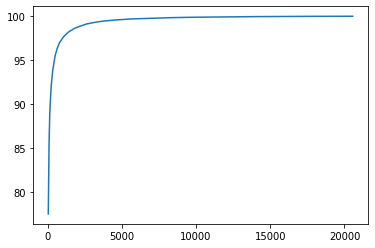

In [27]:
xlabel = [i for i in range(50,total_tags,50)]
plt.plot(xlabel,questions_covered)

In [28]:
multilabel_yx = tags_to_choose(200)
print("number of questions that are not covered :", questions_covered_fn(200),"out of ", total_qs)

number of questions that are not covered : 27890 out of  300000


In [30]:
print("Number of tags in sample :", Y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/Y.shape[1])*100,"%)")

Number of tags in sample : 20551
number of tags taken : 200 ( 0.9731886526203104 %)


In [31]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [32]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (240000, 200)
Number of data points in test data : (60000, 200)


# Converting X to Vector

In [33]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:38.843329


# Evaluation Metrics:


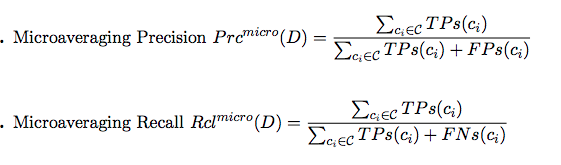


* In micro-averaging method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them. And the micro-average F1-Score will be simply the harmonic mean of above two equations.










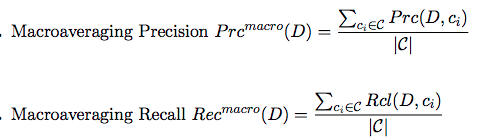


* Macro-averaging is straight forward. We just take the average of the precision and recall of the system on different sets.

#### Hamming Loss

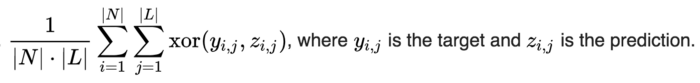

# Model

In [34]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.2708333333333333
macro f1 score : 0.3768114225338666
micro f1 scoore : 0.49789945526543244
hamming loss : 0.00624475
Precision recall report :
               precision    recall  f1-score   support

           0       0.66      0.22      0.33      5007
           1       0.78      0.44      0.56      5348
           2       0.84      0.57      0.68      4921
           3       0.75      0.42      0.54      4828
           4       0.86      0.65      0.74      4228
           5       0.95      0.75      0.84      4936
           6       0.50      0.45      0.48      1834
           7       0.75      0.33      0.46      2317
           8       0.77      0.42      0.55      1765
           9       0.48      0.08      0.14      1401
          10       0.88      0.62      0.73      2173
          11       0.55      0.20      0.29      2209
          12       0.83      0.61      0.71      2074
          13       0.64      0.19      0.29      1808
          14       0.55      0.2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
classifier = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.2617
macro f1 score : 0.33632228121932783
micro f1 scoore : 0.47546464541584466
hamming loss : 0.00631475
Precision recall report :
               precision    recall  f1-score   support

           0       0.67      0.24      0.35      5007
           1       0.79      0.41      0.54      5348
           2       0.85      0.55      0.67      4921
           3       0.76      0.41      0.53      4828
           4       0.87      0.64      0.73      4228
           5       0.96      0.72      0.82      4936
           6       0.51      0.43      0.46      1834
           7       0.77      0.33      0.46      2317
           8       0.80      0.42      0.55      1765
           9       0.51      0.08      0.13      1401
          10       0.89      0.57      0.70      2173
          11       0.56      0.20      0.30      2209
          12       0.85      0.60      0.71      2074
          13       0.64      0.17      0.27      1808
          14       0.58      0.28      0.38

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear'))
# classifier.fit(x_train_multilabel, y_train)
# predictions = classifier.predict(x_test_multilabel)

# print("accuracy :",metrics.accuracy_score(y_test,predictions))
# print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_test,predictions))
# print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [37]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.2886
macro f1 score : 0.33475497891858597
micro f1 scoore : 0.5093176212661003
hamming loss : 0.005968333333333333
Precision recall report :
               precision    recall  f1-score   support

           0       0.69      0.14      0.23      5007
           1       0.78      0.48      0.60      5348
           2       0.83      0.61      0.70      4921
           3       0.76      0.43      0.55      4828
           4       0.84      0.70      0.76      4228
           5       0.94      0.78      0.86      4936
           6       0.53      0.48      0.51      1834
           7       0.85      0.26      0.40      2317
           8       0.79      0.50      0.61      1765
           9       0.83      0.00      0.01      1401
          10       0.87      0.69      0.77      2173
          11       0.55      0.00      0.01      2209
          12       0.82      0.66      0.73      2074
          13       0.74      0.19      0.30      1808
          14       0.69      0.11 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
preprossed_data = []
questions_proccesed = 0
data_size = 100000

# Giving more weight to title

In [39]:
start = datetime.now()
questions_with_code=0
for i in range(min(data_size, len(questions))):
    is_code = 0

    title = df['Title'][i]
    question = df['Body'][i]
    tag = df['Tag'][i]
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=removeHtmlTags(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+ str(title)+" "+ str(title)+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    tup = (question,code,is_code,tag)
    preprossed_data.append(tup)
    questions_proccesed += 1
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)
    
print("Time take to execute this cell ", datetime.now()-start)

number of questions completed= 10000
number of questions completed= 20000
number of questions completed= 30000
number of questions completed= 40000
number of questions completed= 50000
number of questions completed= 60000
number of questions completed= 70000
number of questions completed= 80000
number of questions completed= 90000
number of questions completed= 100000
Time take to execute this cell  0:02:37.220965


In [40]:
data = pd.DataFrame(preprossed_data[:data_size], columns =['question', 'code', 'is_code','tag'])
data.drop(['is_code','code'], axis =1, inplace=True)

In [41]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [42]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:57.198792


In [43]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.30665
macro f1 score : 0.44298434541242815
micro f1 scoore : 0.5509207941971491
hamming loss : 0.00577325
Precision recall report :
               precision    recall  f1-score   support

           0       0.65      0.31      0.42      2072
           1       0.81      0.51      0.63      1547
           2       0.86      0.61      0.71      1497
           3       0.78      0.45      0.57      1266
           4       0.91      0.72      0.81      1181
           5       0.99      0.73      0.84       940
           6       0.85      0.64      0.73      1124
           7       0.71      0.33      0.45       903
           8       0.82      0.44      0.58       827
           9       0.55      0.16      0.25       782
          10       0.90      0.65      0.75       782
          11       0.59      0.32      0.41       599
          12       0.89      0.64      0.74       632
          13       0.64      0.23      0.33       558
          14       0.62      0.34      0.44

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

In [44]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.32875
macro f1 score : 0.41495314751325574
micro f1 scoore : 0.5659547489796727
hamming loss : 0.005477
Precision recall report :
               precision    recall  f1-score   support

           0       0.68      0.29      0.41      2072
           1       0.82      0.56      0.66      1547
           2       0.86      0.64      0.73      1497
           3       0.83      0.43      0.57      1266
           4       0.90      0.74      0.81      1181
           5       0.98      0.78      0.87       940
           6       0.86      0.70      0.77      1124
           7       0.80      0.29      0.42       903
           8       0.79      0.47      0.59       827
           9       0.58      0.16      0.25       782
          10       0.91      0.73      0.81       782
          11       0.63      0.23      0.34       599
          12       0.89      0.63      0.74       632
          13       0.72      0.23      0.35       558
          14       0.67      0.30      0.42  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

In [45]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear'))
# classifier.fit(x_train_multilabel, y_train)
# predictions = classifier.predict(x_test_multilabel)

# print("accuracy :",metrics.accuracy_score(y_test,predictions))
# print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_test,predictions))
# print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [46]:
from sklearn.decomposition import PCA
 

In [47]:
x_test_multilabel.shape

(20000, 93012)

In [48]:
# pca = PCA(n_components=200)
# X_train = pca.fit_transform(x_train_multilabel) 
# X_test = pca.transform(x_test_multilabel) 

In [49]:
from sklearn.decomposition import TruncatedSVD

In [50]:
clf = TruncatedSVD(1000)
X_train = clf.fit_transform(x_train_multilabel)
X_test = clf.transform(x_test_multilabel)

In [51]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.28915
macro f1 score : 0.3776809632025133
micro f1 scoore : 0.5242695193996487
hamming loss : 0.005959
Precision recall report :
               precision    recall  f1-score   support

           0       0.61      0.35      0.45      2072
           1       0.81      0.46      0.59      1547
           2       0.84      0.64      0.72      1497
           3       0.82      0.41      0.55      1266
           4       0.91      0.72      0.80      1181
           5       0.99      0.70      0.82       940
           6       0.86      0.61      0.72      1124
           7       0.71      0.27      0.39       903
           8       0.80      0.43      0.56       827
           9       0.54      0.16      0.25       782
          10       0.88      0.65      0.75       782
          11       0.59      0.26      0.36       599
          12       0.85      0.68      0.75       632
          13       0.69      0.17      0.28       558
          14       0.60      0.34      0.43   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

In [52]:
# Why accuracy is low
a = y_test.toarray()[:3]
b = predictions.toarray()[:3]
print("a = ",a)
print("b = ",b)

a =  [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0

In [53]:
print("accuracy :",metrics.accuracy_score(a,b))

accuracy : 0.3333333333333333


In [54]:
tests = []
preds = []
for k in y_test.toarray():
    tests.extend(k)

for p in predictions.toarray():
    preds.extend(p)

In [55]:
print("accuracy :",metrics.accuracy_score(preds,tests))

accuracy : 0.994041
